## Load libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder


## Read dataset

In [ ]:
data = pd.read_csv('/content/data_set_hackathon.csv')

In [ ]:
data.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


## Data preparation

In [ ]:
data['items'] = pd.to_numeric(data['items'], errors='coerce').fillna(0).astype(int)

In [ ]:
data['Curr'].unique()

array(['RUB', 'DKK', 'NOK', 'EUR', 'CHF', 'SEK', 'CZK', 'PLN', 'GBP'],
      dtype=object)

In [ ]:
# Define exchange rates to EUR for each currency
exchange_rates = {
    'RUB': 0.01,
    'DKK': 0.13,
    'NOK': 0.08,
    'CHF': 1.06,
    'SEK': 0.09,
    'CZK': 0.04,
    'PLN': 0.23,
    'GBP': 1.17
}
def convert_to_eur(row, exchange_rates):
    currency = row['Curr']
    if currency in exchange_rates:
        return row['value'] * exchange_rates[currency]
    return row['value']  # Assumes EUR values don't need conversion

# Convert all values to EUR
data['Value EUR'] = data.apply(lambda row: convert_to_eur(row, exchange_rates), axis=1)


In [ ]:
data.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Value EUR
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,23.3700
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,101.6025
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,29.9250
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,40.6125
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,22.0875


In [ ]:
# Convert dates to datetime objects for easier analysis
data['order_date'] = pd.to_datetime(data['order_date'])
data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'])

<ipython-input-93-b5ccd78e8e9c>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['order_date'] = pd.to_datetime(data['order_date'])
<ipython-input-93-b5ccd78e8e9c>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'])


In [ ]:
# Calculate the lead time (difference between order date and requested delivery date)
data['Lead Time'] = (data['requested_delivery_date'] - data['order_date']).dt.days

In [ ]:
missing_values = data.isnull().sum()
missing_values

order_date                 0
requested_delivery_date    0
Customer Country Code      0
Product Code               0
Description                0
order_type                 0
Customer Order Code        0
value                      0
Curr                       0
items                      0
Route                      0
Value EUR                  0
Lead Time                  0
dtype: int64

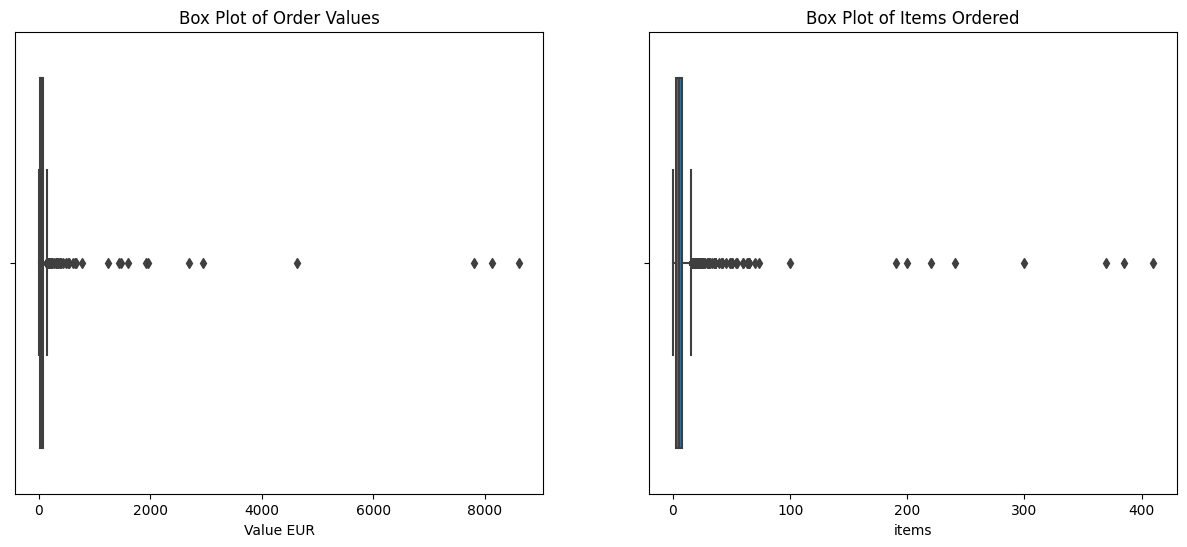

In [ ]:
# Creating box plots to check for outliers in 'Value' and 'Items'

plt.figure(figsize=(15, 6))

# Box plot for 'Value'
plt.subplot(1, 2, 1)
sns.boxplot(x=data['Value EUR'])
plt.title('Box Plot of Order Values')

# Box plot for 'Items'
plt.subplot(1, 2, 2)
sns.boxplot(x=data['items'])
plt.title('Box Plot of Items Ordered')

plt.show()

In [ ]:
data = data[(data['Value EUR'] <= 2000) & (data['items'] <= 100)]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 0 to 2419
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2412 non-null   datetime64[ns]
 1   requested_delivery_date  2412 non-null   datetime64[ns]
 2   Customer Country Code    2412 non-null   object        
 3   Product Code             2412 non-null   object        
 4   Description              2412 non-null   object        
 5   order_type               2412 non-null   object        
 6   Customer Order Code      2412 non-null   int64         
 7   value                    2412 non-null   float64       
 8   Curr                     2412 non-null   object        
 9   items                    2412 non-null   int64         
 10  Route                    2412 non-null   object        
 11  Value EUR                2412 non-null   float64       
 12  Lead Time                2412 non-

##EDA

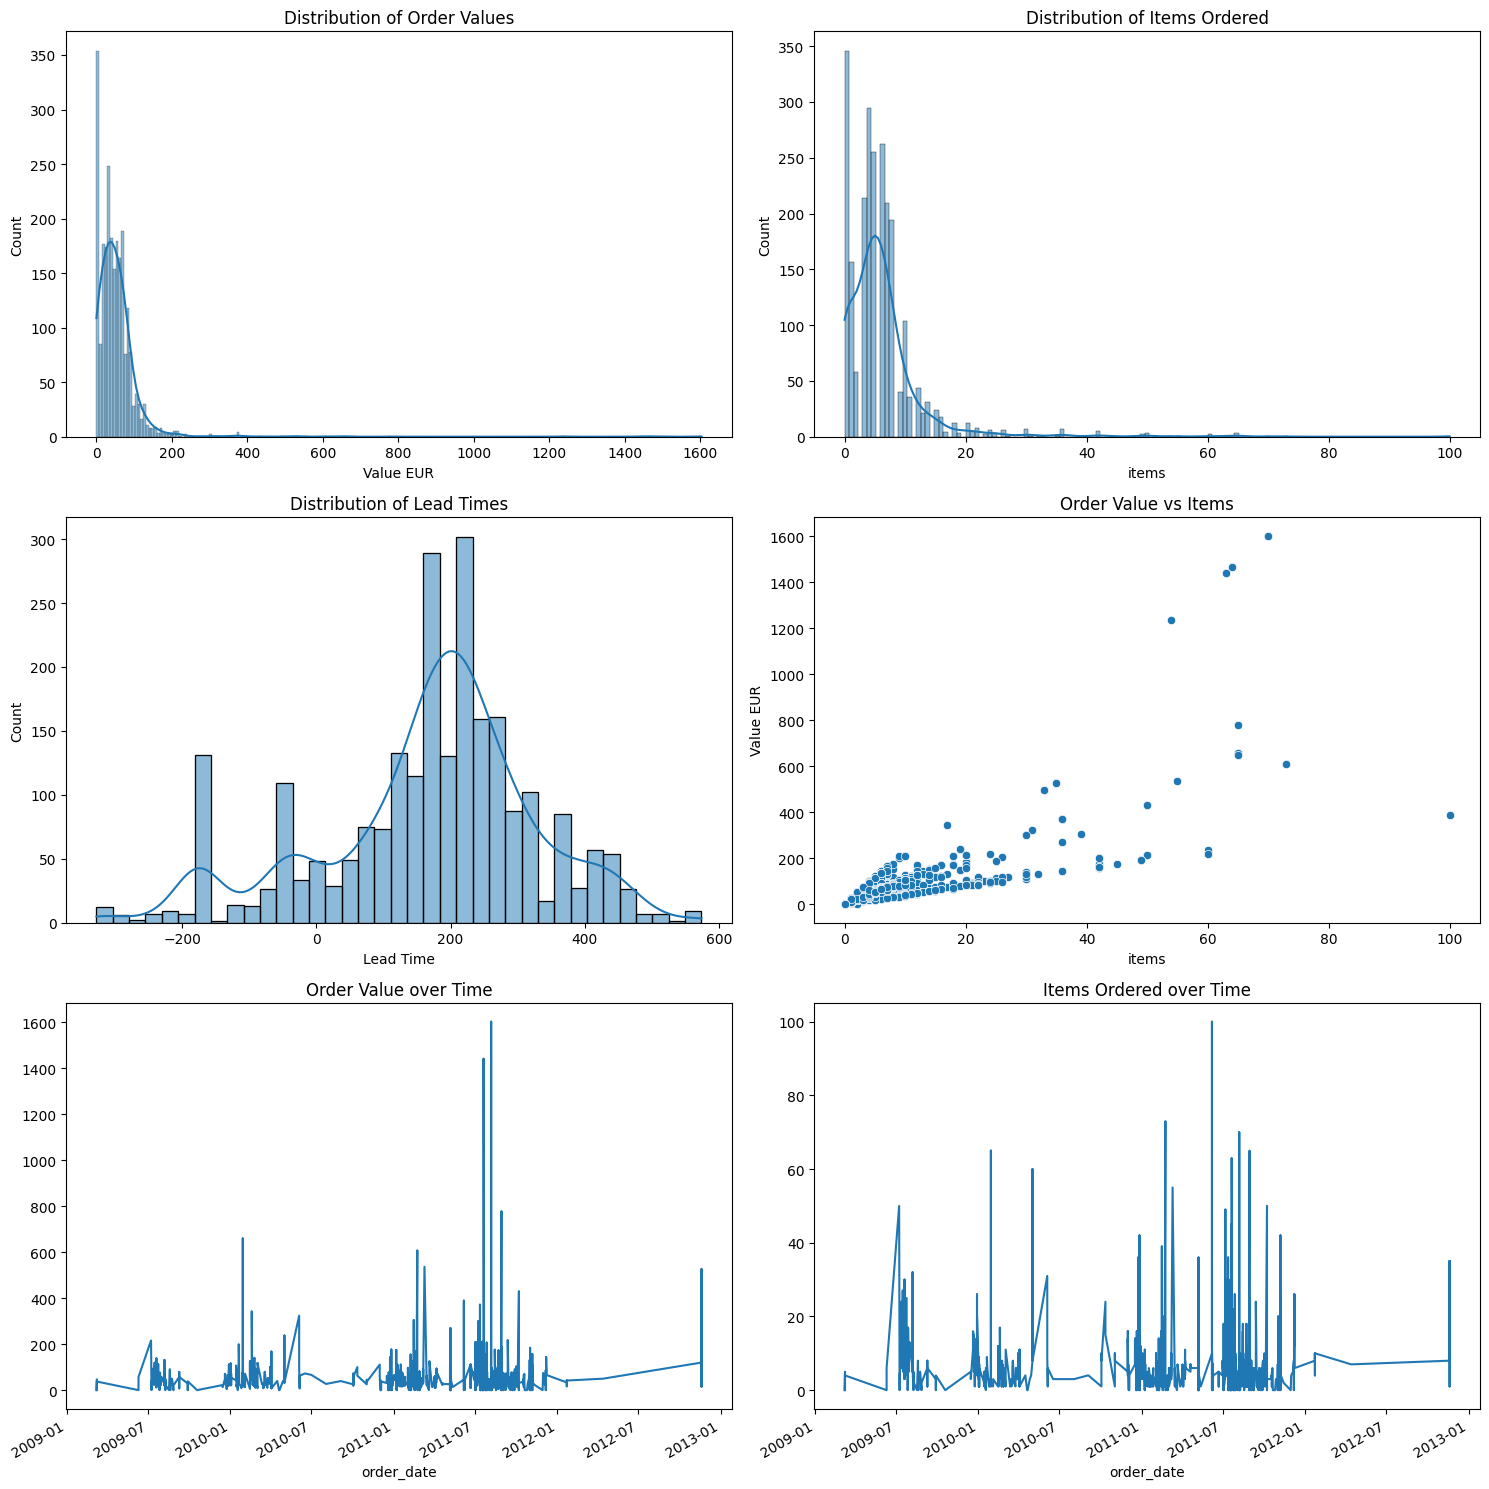

In [ ]:
# Creating a subplot grid for visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Distribution of Order Values
sns.histplot(data['Value EUR'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Order Values')
# Distribution of Items Ordered
sns.histplot(data['items'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Items Ordered')

# Distribution of Lead Time
sns.histplot(data['Lead Time'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Lead Times')

# Order Value vs Items
sns.scatterplot(x='items', y='Value EUR', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Order Value vs Items')

# Order Value over Time
data.set_index('order_date')['Value EUR'].plot(ax=axes[2, 0])
axes[2, 0].set_title('Order Value over Time')

# Items Ordered over Time
data.set_index('order_date')['items'].plot(ax=axes[2, 1])
axes[2, 1].set_title('Items Ordered over Time')

plt.tight_layout()
plt.show()

## Feature engineering

In [ ]:
# Extracting year and month from Order Date and Requested Delivery Date
data['Order Year'] = data['order_date'].dt.year
data['Order Month'] = data['order_date'].dt.month
data['Requested Delivery Year'] = data['requested_delivery_date'].dt.year
data['Requested Delivery Month'] = data['requested_delivery_date'].dt.month

In [ ]:
data.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Value EUR,Lead Time,Order Year,Order Month,Requested Delivery Year,Requested Delivery Month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,23.3700,199,2009,7,2010,1
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,101.6025,252,2009,7,2010,3
2,2009-07-16,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,29.9250,260,2009,7,2010,4
3,2009-07-17,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,40.6125,259,2009,7,2010,4
4,2009-07-21,2010-01-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,22.0875,165,2009,7,2010,1


In [ ]:
data['Customer Country Code'].unique()

array(['RU', 'DK', 'NO', 'FI', 'NL', 'ES', 'IT', 'FR', 'CH', 'PT', 'SE',
       'AT', 'DE', 'SK', 'CZ', 'PL', 'BY', 'BG', 'US', 'CY', 'RO', 'BE',
       'SI', 'EE', 'HR', 'GB', 'GR', 'GL', 'XK', 'AD', 'CE'], dtype=object)

In [ ]:
country_code_mapping = {'RU': 1, 'DK': 2, 'NO': 3, 'FI': 4, 'NL': 5, 'ES': 6, 'IT': 7, 'FR': 8,
    'CH': 9, 'PT': 10, 'SE': 11, 'AT': 12, 'DE': 13, 'SK': 14, 'CZ': 15,
    'PL': 16, 'BY': 17, 'BG': 18, 'US': 19, 'CY': 20, 'RO': 21, 'BE': 22,
    'SI': 23, 'EE': 24, 'HR': 25, 'GB': 26, 'GR': 27, 'GL': 28, 'XK': 29,
    'AD': 30, 'CE': 31}
data['Customer Country Code Numeric'] = data['Customer Country Code'].map(country_code_mapping)

In [ ]:
data['Description'].unique()

array(['Parka Outdoor Lifestyle STD'], dtype=object)

In [ ]:
data['Route'].unique()

array(['RU0001', 'DK01FR', 'NO02FR', 'FI01FR', 'BE0001', 'SP0003',
       'IT0000', 'FR0001', 'CH0001', 'PT0001', 'SE02FR', 'AT0003',
       'DE0005', '1', 'FR01CZ', 'FR02BY', 'FR02BG', 'FR02UA', 'FR02KZ',
       'FR02RO', 'SI0001', 'CZ0002', 'RO1001', 'FR01CH', 'FR02EE',
       'FR01NL', 'FR01SI', 'FI0003', 'FR01DE', 'GB0005', 'FR02GR',
       'AL0002', 'AD0001', 'CE5001'], dtype=object)

In [ ]:
route_mapping = {'RU0001': 1, 'DK01FR': 2, 'NO02FR': 3, 'FI01FR': 4, 'BE0001': 5,
    'SP0003': 6, 'IT0000': 7, 'FR0001': 8, 'CH0001': 9, 'PT0001': 10,
    'SE02FR': 11, 'AT0003': 12, 'DE0005': 13, '1': 14, 'FR01CZ': 15,
    'FR02BY': 16, 'FR02BG': 17, 'FR02UA': 18, 'FR02KZ': 19, 'FR02RO': 20,
    'SI0001': 21, 'CZ0002': 22, 'RO1001': 23, 'FR01CH': 24, 'FR02EE': 25,
    'FR01NL': 26, 'FR01SI': 27, 'FI0003': 28, 'FR01DE': 29, 'GB0005': 30,
    'FR02GR': 31, 'AL0002': 32, 'AD0001': 33, 'CE5001': 34}
data['Route Numeric'] = data['Route'].map(route_mapping)

In [ ]:
data['Product Code'].unique()

array(['L10705000', 'L10705100', 'L10705200', 'L10705300', 'L10705400',
       'L10705500', 'L10705600', 'L10705700', 'L10850600', 'L10850700',
       'L10850800', 'L10850900', 'L10852800', 'L10852900', 'L10853100',
       'L12134400', 'L12134500', 'L12134600', 'L12134700', 'L12135800',
       'L12135900', 'L12136000', 'L12136100', 'L12916800', 'L12916900',
       'L12917000', 'L12917100', 'L12917700', 'L12917800', 'L12917900',
       'L12918000', 'L12918400', 'L12918500', 'L12918600', 'L12918700',
       'L12918800', 'L12918900', 'L12919000', 'L12919100', 'L12919200'],
      dtype=object)

In [ ]:
product_code_mapping = {
    'L10705000': 1, 'L10705100': 2, 'L10705200': 3, 'L10705300': 4,
    'L10705400': 5, 'L10705500': 6, 'L10705600': 7, 'L10705700': 8,
    'L10850600': 9, 'L10850700': 10, 'L10850800': 11, 'L10850900': 12,
    'L10852800': 13, 'L10852900': 14, 'L10853100': 15, 'L12134400': 16,
    'L12134500': 17, 'L12134600': 18, 'L12134700': 19, 'L12135800': 20,
    'L12135900': 21, 'L12136000': 22, 'L12136100': 23, 'L12916800': 24,
    'L12916900': 25, 'L12917000': 26, 'L12917100': 27, 'L12917700': 28,
    'L12917800': 29, 'L12917900': 30, 'L12918000': 31, 'L12918400': 32,
    'L12918500': 33, 'L12918600': 34, 'L12918700': 35, 'L12918800': 36,
    'L12918900': 37, 'L12919000': 38, 'L12919100': 39, 'L12919200': 40
}

# Use this mapping to create a new column in your DataFrame
data['Product Code Numeric'] = data['Product Code'].map(product_code_mapping)

In [ ]:
data.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Value EUR,Lead Time,Order Year,Order Month,Requested Delivery Year,Requested Delivery Month,Customer Country Code Numeric,Route Numeric,Product Code Numeric
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,23.3700,199,2009,7,2010,1,1,1,1
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,101.6025,252,2009,7,2010,3,1,1,1
2,2009-07-16,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,29.9250,260,2009,7,2010,4,1,1,1
3,2009-07-17,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,40.6125,259,2009,7,2010,4,1,1,1
4,2009-07-21,2010-01-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,22.0875,165,2009,7,2010,1,1,1,1


In [ ]:
data

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Value EUR,Lead Time,Order Year,Order Month,Requested Delivery Year,Requested Delivery Month,Customer Country Code Numeric,Route Numeric,Product Code Numeric
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,23.3700,199,2009,7,2010,1,1,1,1
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,101.6025,252,2009,7,2010,3,1,1,1
2,2009-07-16,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,29.9250,260,2009,7,2010,4,1,1,1
3,2009-07-17,2010-04-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,40.6125,259,2009,7,2010,4,1,1,1
4,2009-07-21,2010-01-02,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,22.0875,165,2009,7,2010,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819196,128.52,EUR,12,FI0003,128.5200,217,2011,7,2012,2,25,28,40
2416,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819201,128.52,EUR,12,FI0003,128.5200,217,2011,7,2012,2,25,28,40
2417,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819206,128.52,EUR,12,FI0003,128.5200,217,2011,7,2012,2,25,28,40
2418,2011-07-13,2012-02-15,HR,L12919200,Parka Outdoor Lifestyle STD,VO,3200819210,107.10,EUR,10,FI0003,107.1000,217,2011,7,2012,2,25,28,40


## Time series analysis

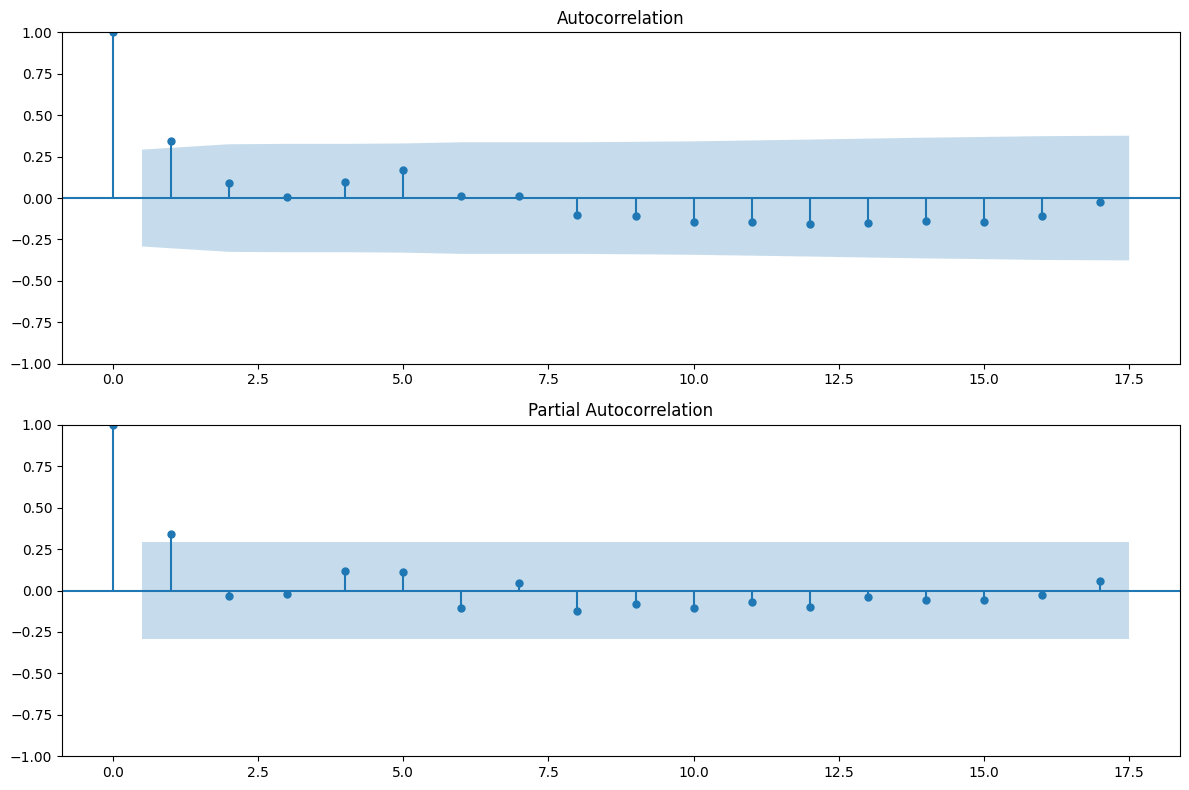

(-4.531617727941679, 0.0001723289930552517)

In [ ]:
# Aggregate data to monthly frequency
monthly_data = data.resample('M', on='order_date')['items'].sum()

# Check for stationarity using Augmented Dickey-Fuller test
adf_result = adfuller(monthly_data)

# Generate ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF
plot_acf(monthly_data, lags=17, ax=ax1)

# Plot the PACF
plot_pacf(monthly_data, lags=17, ax=ax2)

plt.tight_layout()
plt.show()

# Output the result of ADF test
adf_result[:2]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a non-seasonal ARIMA model (ARIMA)
arima_model = ARIMA(monthly_data, order=(1, 0, 1))
arima_results = arima_model.fit()

# Fit a simpler seasonal SARIMA model
sarima_simpler_model = SARIMAX(monthly_data,
                               order=(1, 0, 1),
                               seasonal_order=(1, 0, 0, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
sarima_simpler_results = sarima_simpler_model.fit()

# Summaries of the models
arima_summary = arima_results.summary()
sarima_simpler_summary = sarima_simpler_results.summary()

(arima_summary, sarima_simpler_summary)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                  items   No. Observations:                   45
 Model:                 ARIMA(1, 0, 1)   Log Likelihood                -361.015
 Date:                Mon, 11 Dec 2023   AIC                            730.029
 Time:                        22:48:02   BIC                            737.256
 Sample:                    03-31-2009   HQIC                           732.723
                          - 11-30-2012                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const        329.2325    474.089      0.694      0.487    -599.965    1258.429
 ar.L1          0.2769      1.160      0.239      0.811      -1.997   

In [ ]:
arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  items   No. Observations:                   45
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -361.015
Date:                Mon, 11 Dec 2023   AIC                            730.029
Time:                        22:48:02   BIC                            737.256
Sample:                    03-31-2009   HQIC                           732.723
                         - 11-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        329.2325    474.089      0.694      0.487    -599.965    1258.429
ar.L1          0.2769      1.160      0.239      0.811      -1.997       2.551
ma.L1          0.0692      1.216      0.057      0.955      -2.315       2.453
sigma2      5.427e+05   9.64e+04      5.632      0.000    3.54e+05    7.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1693.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             5.16
Prob(H) (two-sided):                  0.39   Kurtosis:                        31.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarima_simpler_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               items   No. Observations:                   45
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -262.253
Date:                             Mon, 11 Dec 2023   AIC                            532.507
Time:                                     22:48:02   BIC                            538.370
Sample:                                 03-31-2009   HQIC                           534.450
                                      - 11-30-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.577      0.961      0.337      -0.577       1.685
ma.L1         -0.1249      0.758     -0.165      0.869      -1.612       1.362
ar.S.L12       0.0043      2.428      0.002      0.999      -4.754       4.763
sigma2       7.69e+05   9.22e+04      8.343      0.000    5.88e+05     9.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               645.75
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             4.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

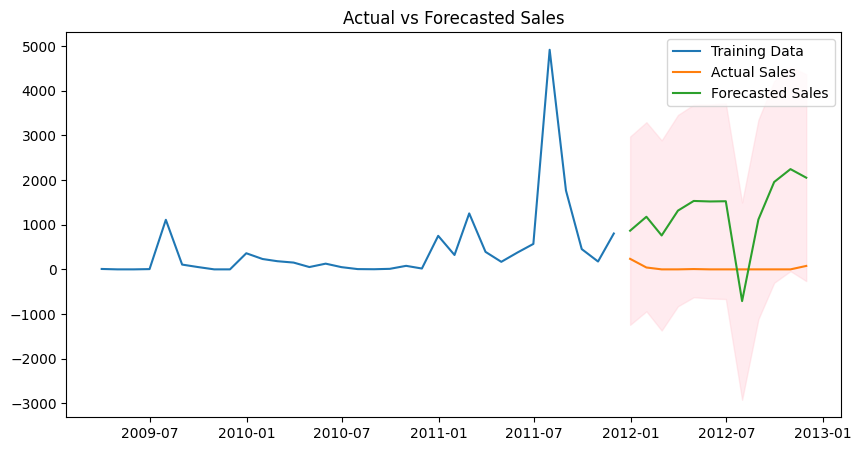

(            actual   forecasted
 2011-12-31     236   865.957779
 2012-01-31      42  1177.980853
 2012-02-29       0   759.330484
 2012-03-31       0  1315.411235
 2012-04-30       7  1532.039153
 2012-05-31       0  1520.466649
 2012-06-30       0  1525.584327
 2012-07-31       0  -710.690136
 2012-08-31       0  1116.356018
 2012-09-30       0  1956.285260
 2012-10-31       0  2245.049833
 2012-11-30      77  2052.947104,
 1368.008235981533)

In [ ]:
# Define the train and test set
train_data = monthly_data.iloc[:-12]
test_data = monthly_data.iloc[-12:]

# Fit the SARIMA model on the training set
best_model = SARIMAX(train_data,
                     order=(1, 0, 1),
                     seasonal_order=(1, 0, 0, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_results = best_model.fit()

# Make forecast on the testing set
forecast = best_results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Compare forecasted values with actual values in the testing set
comparison_df = pd.DataFrame({'actual': test_data, 'forecasted': forecast_mean})

# Calculate Mean Absolute Error (MAE) as a performance metric
mae = np.mean(np.abs(comparison_df['forecasted'] - comparison_df['actual']))

# Plot the actual vs forecasted values
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Sales')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.show()

comparison_df, mae

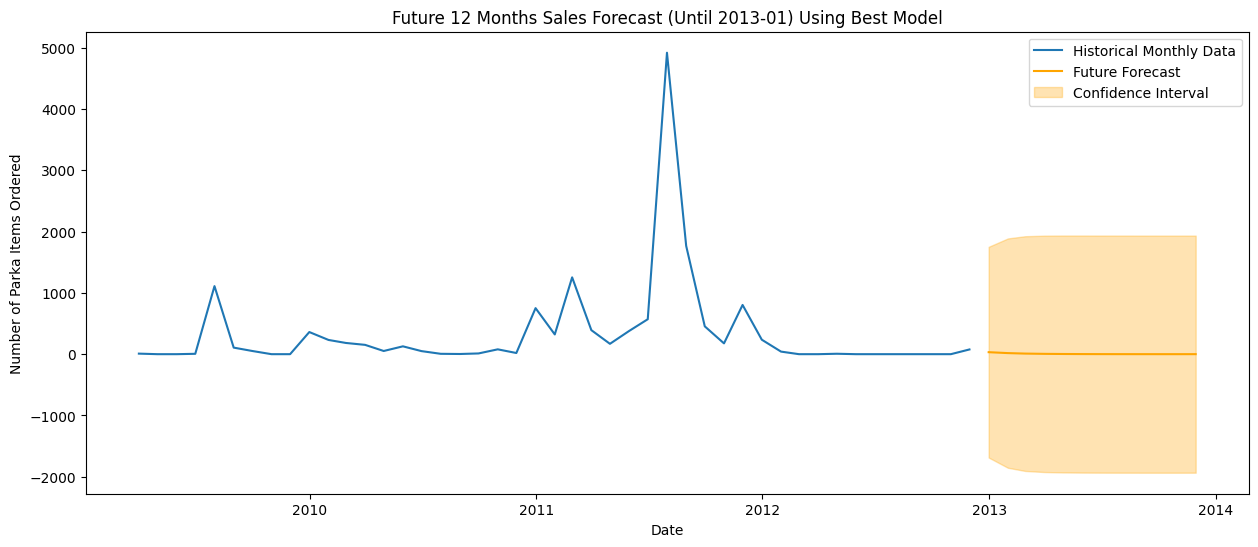

In [ ]:
# Fit the SARIMA model with the specified parameters on the entire dataset
best_model = SARIMAX(monthly_data,
                     order=(1, 0, 1),
                     seasonal_order=(1, 0, 0, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_results = best_model.fit()

# Forecast future 12 months beyond the available data
future_forecast = best_results.get_forecast(steps=12)
future_forecast_mean = future_forecast.predicted_mean
future_forecast_conf_int = future_forecast.conf_int()

# Creating a new index for the future forecasted values
future_forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')

# Creating a DataFrame for the future forecasted values
future_forecast_df = pd.DataFrame({'Forecast': future_forecast_mean}, index=future_forecast_index)
future_forecast_conf_df = pd.DataFrame(future_forecast_conf_int, index=future_forecast_index)

# Plotting the original data and future forecasts
plt.figure(figsize=(15, 6))
plt.plot(monthly_data, label='Historical Monthly Data')
plt.plot(future_forecast_df.index, future_forecast_df['Forecast'], label='Future Forecast', color='orange')
plt.fill_between(future_forecast_conf_df.index,
                 future_forecast_conf_df.iloc[:, 0],
                 future_forecast_conf_df.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title('Future 12 Months Sales Forecast (Until 2013-01) Using Best Model')
plt.xlabel('Date')
plt.ylabel('Number of Parka Items Ordered')
plt.legend()
plt.show()

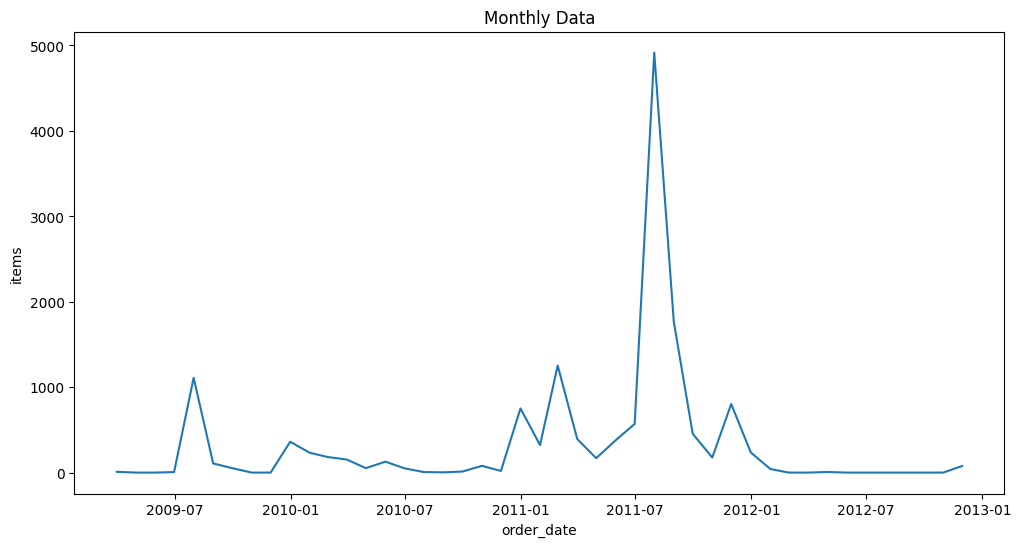

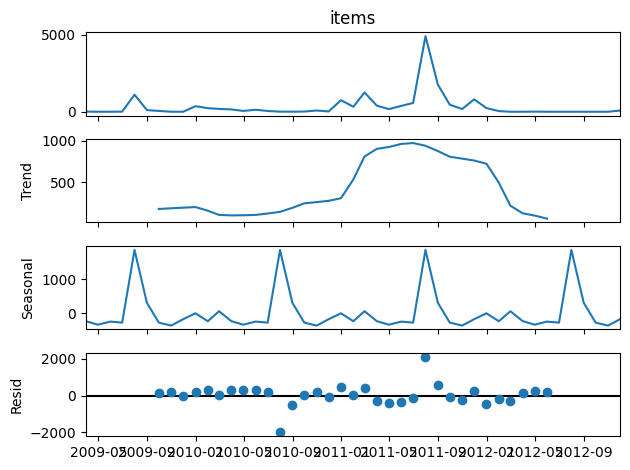

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Plot the data
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_data)
plt.title('Monthly Data')
plt.show()

# Seasonal Decomposition
result = seasonal_decompose(monthly_data, model='additive')
result.plot()
plt.show()

## Multiple Linear Regression

<ipython-input-118-9bc712a100c2>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


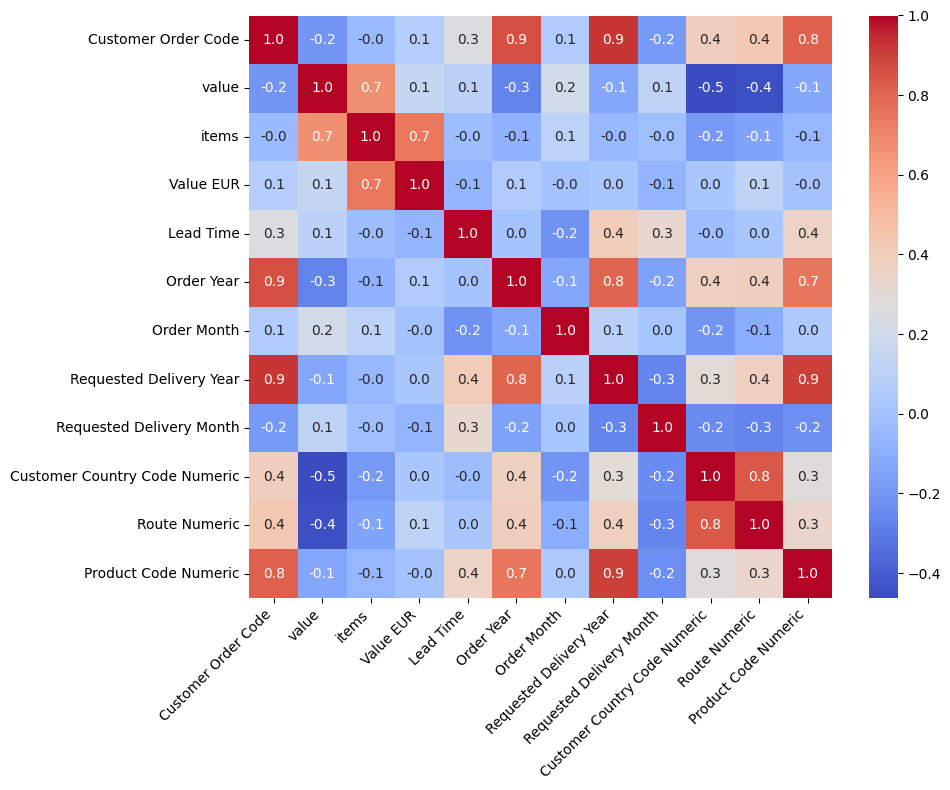

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# First, calculate the correlation matrix
corr_matrix = data.corr()

# Now, plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', cbar=True, square=True,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

# Rotate the labels on the x-axis for better readability.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
X = data[['Value EUR', 'Order Month', 'Order Year', 'Customer Country Code Numeric','Product Code Numeric','Route Numeric']]
y = data['items']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Building the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predicting on the test set
y_pred = model.predict(X_test)
y_pred

array([ 4.00903619e-01,  5.81619052e+00,  5.31006317e+00,  5.79378614e+00,
        6.56359474e+00, -7.93346261e-02,  6.26620925e+00,  3.87813965e+00,
        4.12753992e+00,  6.77919772e+00,  8.45449277e+00,  6.76126416e+00,
        6.82044747e+00,  4.86163658e+00,  7.16081675e+00,  3.76160908e+00,
        3.89327486e+00,  1.13463525e+01,  2.94745731e+00,  5.73041048e+00,
        9.74902055e+00,  7.74574942e+00,  2.83523441e+00,  7.23288171e+00,
        7.58640951e+00,  4.20111889e+00,  3.84777563e+00,  1.04954009e+01,
        8.83605829e+00,  7.94718795e+00,  1.99036211e+00,  3.63996584e+00,
        4.25542063e+00,  1.04954009e+01,  4.39623075e+00,  4.88576977e+00,
        7.50024853e+00,  3.78088713e+00,  2.57616030e+00,  4.17726781e+00,
        2.79415444e+00,  6.54106662e+00,  7.14978007e+00,  7.58640951e+00,
       -7.93346261e-02,  1.20685891e+01,  1.15374764e+01,  7.31837272e+00,
        8.41289206e+00,  1.87917085e+00,  7.49556260e+00,  7.53235624e+00,
       -1.22517155e-01,  

In [ ]:
# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = model.coef_
intercept = model.intercept_

mse, r2, coefficients, intercept

(14.482703228909932,
 0.6241352946629144,
 array([ 0.06978296,  0.14368919, -1.23378161,  0.03023545,  0.0531133 ,
        -0.16891601]),
 2482.6955959843635)

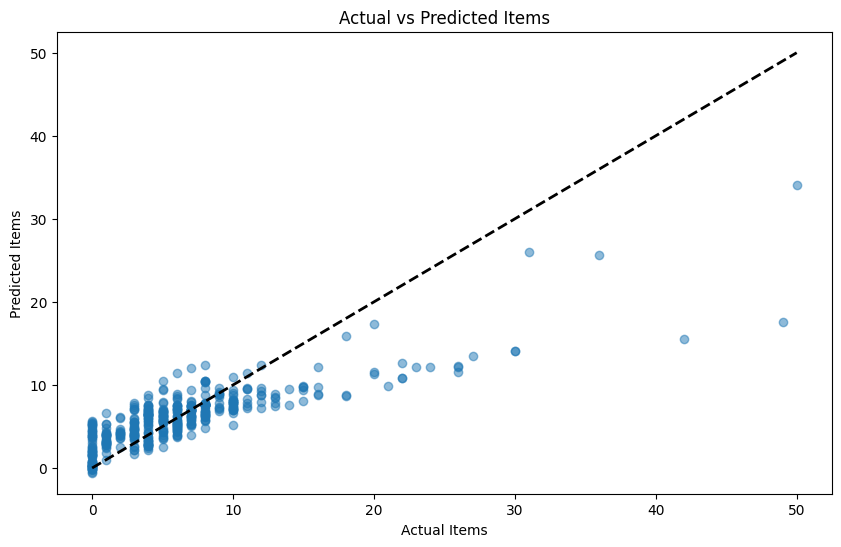

In [ ]:
# Visualization of Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Items')
plt.ylabel('Predicted Items')
plt.title('Actual vs Predicted Items')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Choice Model

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.12      0.03      0.05        31
           2       0.33      0.09      0.14        45
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        13
           7       0.35      0.88      0.51       169
           8       0.32      0.13      0.18        55
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        31
          12       0.53      0.21      0.30        48

    accuracy                           0.35       483
   macro avg       0.14      0.11      0.10       483
weighted avg       0.25      0.35      0.24       483



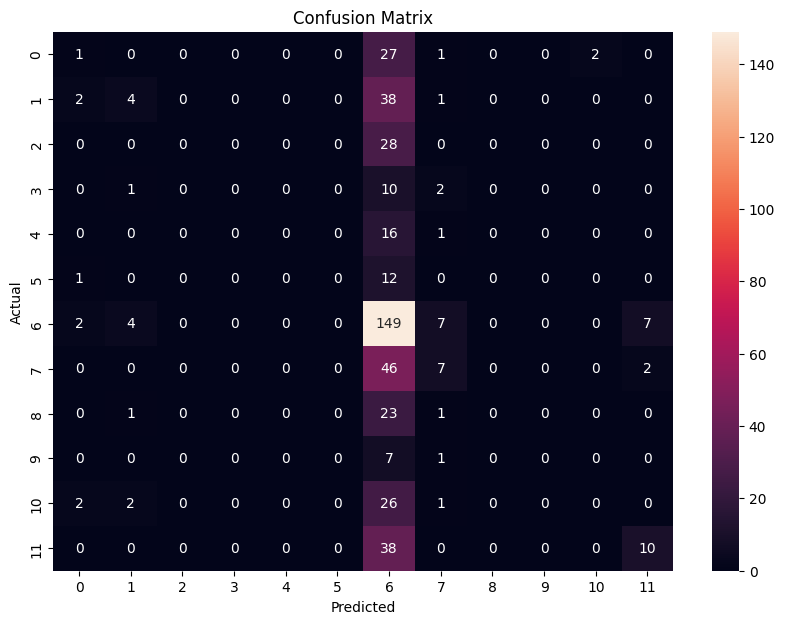

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Preparing the feature matrix 'X' and target vector 'y'
X = data[['Value EUR', 'Order Year', 'Customer Country Code Numeric', 'Product Code Numeric', 'Route Numeric', 'items']]
y = data['Order Month']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Logistic Regression model
choice_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
choice_model.fit(X_train_scaled, y_train)

# Predict the choices on the scaled test set
y_pred = choice_model.predict(X_test_scaled)

# Evaluation
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
probabilities = choice_model.predict_proba(X_test)
probabilities

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
# Prepare the feature matrix 'X_new' for the new data.
X_new = data[['Value EUR', 'Order Year', 'Customer Country Code Numeric', 'Product Code Numeric', 'Route Numeric', 'items']]

# Predict the choices for the new data
y_new_pred = choice_model.predict(X_new)

probabilities_new = choice_model.predict_proba(X_new)

data['Predicted Order Month'] = y_new_pred

# And to view the first few predictions:
print(data[['Predicted Order Month']].head())

for i, category in enumerate(choice_model.classes_):
    data[f'Probability of {category}'] = probabilities_new[:, i]

# Checking the classes in the model
print("Classes in the model:", choice_model.classes_)

# Adding probability columns for each class
for i, category in enumerate(choice_model.classes_):
    data[f'Probability of Month {category}'] = probabilities_new[:, i]

print(data.head())


   Predicted Order Month
0                     11
1                     11
2                     11
3                     11
4                     11
Classes in the model: [ 1  2  3  4  5  6  7  8  9 10 11 12]
  order_date requested_delivery_date Customer Country Code Product Code  \
0 2009-07-13              2010-01-28                    RU    L10705000   
1 2009-07-15              2010-03-24                    RU    L10705000   
2 2009-07-16              2010-04-02                    RU    L10705000   
3 2009-07-17              2010-04-02                    RU    L10705000   
4 2009-07-21              2010-01-02                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from datetime import datetime

# Assuming we need to predict for the next year based on the last year in the data
last_year_in_data = data['Order Year'].max()
prediction_year = last_year_in_data + 1

# Generating a DataFrame for all months in the next year for each product
unique_products = data['Product Code'].unique()
future_months = pd.date_range(start=f"{prediction_year}-01-01", end=f"{prediction_year}-12-31", freq='MS')

future_data = pd.DataFrame([(month.year, month.month, product) for month in future_months for product in unique_products],
                           columns=['Order Year', 'Order Month', 'Product Code'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [314]:
data['order_date'] = pd.to_datetime(data['order_date'])
data['Order Year'] = data['order_date'].dt.year
data['Order Month'] = data['order_date'].dt.month

# Aggregate data to get monthly demand for each product
monthly_demand = data.groupby(['Order Year', 'Order Month', 'Product Code']).size().reset_index(name='Demand')

monthly_demand['Product Code Encoded'] = pd.factorize(monthly_demand['Product Code'])[0]

# Prepare the features (X) and target (y)
X = monthly_demand[['Order Year', 'Order Month', 'Product Code Encoded']]
y = monthly_demand['Demand']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor for the prediction model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)
last_year = data['Order Year'].max()
future_years = [last_year + 1]
future_months = list(range(1, 13))  # Months from January to December
product_codes = monthly_demand['Product Code'].unique()

# Creating a DataFrame for prediction
future_data = pd.DataFrame([(year, month, product) for year in future_years for month in future_months for product in product_codes],
                           columns=['Order Year', 'Order Month', 'Product Code'])

# Encoding the 'Product Code' for the future data
future_data['Product Code Encoded'] = pd.factorize(future_data['Product Code'])[0]

# Preparing features for future prediction
X_future = future_data[['Order Year', 'Order Month', 'Product Code Encoded']]

# Predict the future demand
future_demand = regressor.predict(X_future)

# Add the predictions to the future_data DataFrame
future_data['Predicted Demand'] = future_demand

# Assuming 'data' is your DataFrame and 'column_name' is the name of the column you want to drop.
future_data = future_data.drop('Product Code Encoded', axis=1)


# Display the first few rows of the predictions
future_data




,Order Year,Order Month,Product Code,Predicted Demand
0,2013,1,L10705200,9.31
1,2013,1,L10705300,9.31
2,2013,1,L10705400,9.31
3,2013,1,L10705600,9.31
4,2013,1,L10705000,9.31
...,...,...,...,...
475,2013,12,L12918800,2.21
476,2013,12,L12918900,2.12
477,2013,12,L12919000,2.53
478,2013,12,L12919100,2.67
